# intf_ra2ll - Transform Interferogram from Radar to Geographic Coordinates 

trans.dat    - file generated by llt_grid2rat  (r a topo lon lat)"

In [1]:
import sys
!{sys.executable} -m pip install xarray numpy dask scipy matplotlib --upgrade

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree

In [3]:
# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Read (range, azimuth, topo, lon, lat) file

In [4]:
# read coordinates:
# range, azimuth, lon, lat, elevation [ASCII default] 
trans = np.fromfile('asc/F2/topo/trans.dat', dtype=np.float64).reshape([-1,5])

In [5]:
trans.shape

(13728190, 5)

In [6]:
xmin, xmax = trans[:,3].min(),trans[:,3].max()

In [7]:
ymin, ymax = trans[:,4].min(),trans[:,4].max()

## Read lat-lon grid

In [8]:
dem = xr.open_dataset('asc/topo/dem.grd')['Band1']\
    .rename('z')\
    .sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
dem

<xarray.DataArray 'z' (lat: 3320, lon: 5745)>
[19073400 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 37.8 37.8 37.8 37.8 37.8 ... 38.46 38.46 38.47 38.47
  * lon      (lon) float64 47.73 47.73 47.73 47.73 ... 48.88 48.88 48.88 48.88
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

## Read Transform Grid

In [9]:
trans_ra2ll = xr.open_dataarray('asc/topo/trans_ra2ll.grd')
trans_ra2ll

<xarray.DataArray 'trans_ra2ll' (lat: 3320, lon: 5745)>
[19073400 values with dtype=int64]
Coordinates:
  * lat      (lat) float64 37.8 37.8 37.8 37.8 37.8 ... 38.46 38.46 38.47 38.47
  * lon      (lon) float64 47.73 47.73 47.73 47.73 ... 48.88 48.88 48.88 48.88
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs
    node_offset:   1

## Read Interferogram

In [10]:
intf = xr.open_dataarray('asc/F2/intf_all/2021007_2021019/phasefilt.grd')
intf

<xarray.DataArray 'z' (y: 2068, x: 3208)>
[6634144 values with dtype=float32]
Coordinates:
  * x        (x) float64 4.0 12.0 20.0 28.0 ... 2.564e+04 2.565e+04 2.566e+04
  * y        (y) float64 1.0 3.0 5.0 7.0 ... 4.131e+03 4.133e+03 4.135e+03
Attributes:
    long_name:     z
    actual_range:  [-3.14159226  3.14159226]

## Calculate Interferogram Transform to trans.dat

In [11]:
%%time
intf_ys, intf_xs = xr.broadcast(intf.y,intf.x)
intf_yxs = np.stack([intf_ys.values.reshape(-1),intf_xs.values.reshape(-1)], axis=1)
intf_yxs[0]

CPU times: user 65.7 ms, sys: 58.5 ms, total: 124 ms
Wall time: 123 ms


array([1., 4.])

In [12]:
%%time
trans_yxs = np.stack([trans[:,1],trans[:,0]], axis=1)
trans_yxs[0]

CPU times: user 146 ms, sys: 59.2 ms, total: 205 ms
Wall time: 205 ms


array([ 4155.93834841, 25659.54266604])

In [13]:
%%time
tree = cKDTree(intf_yxs, compact_nodes=False, balanced_tree=False)

CPU times: user 871 ms, sys: 77.1 ms, total: 948 ms
Wall time: 965 ms


In [14]:
distance_limit = np.max([intf.y.diff('y')[0],intf.x.diff('x')[0]])
distance_limit

8.0

In [15]:
%%time
d, inds = tree.query(trans_yxs, k = 1, distance_upper_bound=distance_limit, workers=8)

CPU times: user 36 s, sys: 286 ms, total: 36.3 s
Wall time: 10.6 s


In [16]:
%%time
# single integer index mask
intf2trans = np.where(~np.isinf(d), inds, -1)

CPU times: user 115 ms, sys: 52.7 ms, total: 167 ms
Wall time: 215 ms


## Calculate Interferogram Composite Transform to dem.grd

In [17]:
%%time
# produce the same output array
intf_ra2ll = xr.zeros_like(trans_ra2ll).rename('intf_ra2ll')
intf_ra2ll.values = np.where(trans_ra2ll>=0, intf2trans[trans_ra2ll], -1)

CPU times: user 597 ms, sys: 375 ms, total: 972 ms
Wall time: 1.09 s


In [18]:
%%time
compression = dict(zlib=True, complevel=3, chunksizes=[512,512])
# magic: add GMT attribute to prevent coordinates shift for 1/2 pixel
intf_ra2ll.attrs['node_offset'] = np.int32(1)
intf_ra2ll.to_netcdf('asc/topo/intf_ra2ll.grd', encoding={'intf_ra2ll': compression})

CPU times: user 925 ms, sys: 46.7 ms, total: 972 ms
Wall time: 1.07 s


## Cleanup

In [19]:
del trans, intf, dem, tree, intf_yxs, trans_yxs, d, inds, intf2trans, intf_ra2ll

## Apply Composite Transform

In [20]:
%%time
intf = xr.open_dataarray('asc/F2/intf_all/2021007_2021019/phasefilt.grd')
intf

CPU times: user 5.46 ms, sys: 2.08 ms, total: 7.54 ms
Wall time: 7.93 ms


<xarray.DataArray 'z' (y: 2068, x: 3208)>
[6634144 values with dtype=float32]
Coordinates:
  * x        (x) float64 4.0 12.0 20.0 28.0 ... 2.564e+04 2.565e+04 2.566e+04
  * y        (y) float64 1.0 3.0 5.0 7.0 ... 4.131e+03 4.133e+03 4.135e+03
Attributes:
    long_name:     z
    actual_range:  [-3.14159226  3.14159226]

In [21]:
%%time
intf_ra2ll = xr.open_dataarray('asc/topo/intf_ra2ll.grd')
intf_ra2ll

CPU times: user 7.17 ms, sys: 2.78 ms, total: 9.96 ms
Wall time: 8.44 ms


<xarray.DataArray 'intf_ra2ll' (lat: 3320, lon: 5745)>
[19073400 values with dtype=int64]
Coordinates:
  * lat      (lat) float64 37.8 37.8 37.8 37.8 37.8 ... 38.46 38.46 38.47 38.47
  * lon      (lon) float64 47.73 47.73 47.73 47.73 ... 48.88 48.88 48.88 48.88
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs
    node_offset:   1

In [22]:
%%time
intf_ll = xr.DataArray(np.where(intf_ra2ll>=0, intf.values.reshape(-1)[intf_ra2ll], np.nan), coords=intf_ra2ll.coords)

CPU times: user 534 ms, sys: 219 ms, total: 752 ms
Wall time: 855 ms


## Plot

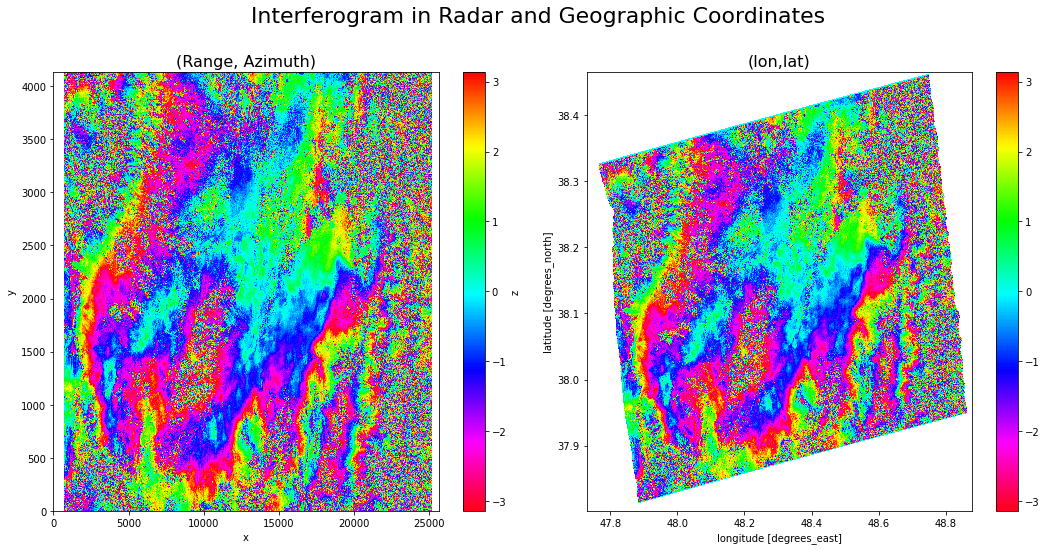

CPU times: user 1.71 s, sys: 195 ms, total: 1.9 s
Wall time: 2.04 s


In [23]:
%%time

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))

intf.plot.imshow(ax=ax1, cmap='hsv_r', interpolation='None')
ax1.set_title('(Range, Azimuth)',fontsize=16)

intf_ll.plot.imshow(ax=ax2, cmap='hsv_r', interpolation='None')
ax2.set_title('(lon,lat)',fontsize=16)

plt.suptitle(f'Interferogram in Radar and Geographic Coordinates', fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.show()